# Misalignment detection (MAD) using supervised regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, lognorm, randint
from scipy.optimize import minimize
import seaborn as sns
from matplotlib import cm
from random import randint
import csv
import torch  #for pytorch


from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import mutual_info_regression, f_regression
from sklearn.metrics import precision_score, recall_score, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score, make_scorer, roc_auc_score 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import linear_kernel

import time
import os
import pickle
import math
import requests
import logging
from time import sleep
from functools import partial
import Levenshtein
import re

%load_ext autoreload
%autoreload 2

from number_match import number_match_pair
# from MAD_scorer import predict_from_sscttc

#Import InferSent as a module
import sys
sys.path.append( '/notebook/arne/MAD/InferSent' )

# make the Jupyter notebook use the full screen width 
from IPython.core.display import display, HTML


display(HTML("<style>.container { width:99% !important; }</style>"))
# set number of cols to display
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 2000)
pd.set_option('max_colwidth',300)

#### Convenience functions

In [2]:
def get_nans(df): return df[df.isnull().any(axis=1)]  #check if one of the rows has a column with a NaN value. 
def info(df): return '%sr x %sc ,  %s nans' % (df.shape[0], df.shape[1] , get_nans(df).shape[0] )  #a function to print number of rows, number of cols and the NaN's. 

#### Load the labeled dataset

In [3]:
data_path='/notebook/arne/MAD/DATA/supervised_dataset/labeled.tsv'
columns=[ 'Txt_source_0ri', 'Txt_target_0ri', 'Txt_source_2_cross' , 'Txt_target_2_cross', 'Txt_source_2_en', 'Txt_target_2_en', 'Lbl_misalign_gold'   ]
data=pd.read_csv(  data_path  , sep='\t', index_col=False, header=None , names=columns , quoting=csv.QUOTE_NONE)  
print( info(data)  )

3406r x 7c ,  0 nans


#### Load InferSent model

In [5]:
#note: you need to use pytorch 0.4 to work with InferSent.
from models import InferSent
model_version = 2
MODEL_PATH = "/notebook/arne/MAD/InferSent/encoder/infersent%s.pkl" % model_version  #AD: load in the InferSent model
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model_infersent = InferSent(params_model)
model_infersent.load_state_dict(torch.load(MODEL_PATH))

W2V_PATH='/notebook/arne/MAD/InferSent/dataset/crawl-300d-2M.vec'
model_infersent.set_w2v_path(W2V_PATH)

# Load embeddings of K most frequent words
model_infersent.build_vocab_k_words(K=1000000)

Vocab size : 1000000


#### Define functions to calculate features

In [6]:
def senlength(pair_of_sentences): return [len(pair_of_sentences[0]), len(pair_of_sentences[1])]

def levenshtein(pair_of_sentences): 
    l = ratio(pair_of_sentences[0].lower(), pair_of_sentences[1].lower())
    assert l >= 0 and l <=1
    return l

def number_match(pair_of_sentences): return number_match_pair(pair_of_sentences)

def calc_semantic_sim_infersent( src_2_en, tgt_2_en ):
    'Input is a list of src sentences translated to english, and a list of tgt sentences translated to english. The sentence embedding of these sentences is calculated in batches on the cpu'
    
    embedding_src_2_en=model_infersent.encode(   src_2_en  , bsize=50, tokenize=True, verbose=False)
    embedding_tgt_2_en=model_infersent.encode(   tgt_2_en  , bsize=50, tokenize=True, verbose=False)

    semantic_similarity=np.diag( linear_kernel( embedding_src_2_en, embedding_tgt_2_en )) / (np.linalg.norm(  embedding_src_2_en, axis=1 ) * np.linalg.norm( embedding_tgt_2_en, axis=1    )  )
    
    return semantic_similarity

#an example

s1='you ensure the worker an adequate basic training' 
s2='you provide in an appropriate basic education with the employee'

print( 'senlength', senlength((s1,s2) ))
print( 'levenshtein', levenshtein( ( s1,s2 )) )
print( 'number-match', number_match( (s1, s2) ))
print( 'semantic similarity InferSent', calc_semantic_sim_infersent(  [ s1 ] , [ s2  ] ) ) 


senlength [48, 63]
levenshtein 0.46846846846846846
number-match 0.5
semantic similarity InferSent [0.7382277]


#### Define gold classification threshold

In [8]:
gold_classification_threshold = 2

def misalign( label_row ):
    if label_row<=gold_classification_threshold:
        return 0
    else:
        return 1

data['Class_misalign_gold'] = data['Lbl_misalign_gold'].apply( misalign) 

In [9]:
from collections import Counter
Counter ( data.Lbl_misalign_gold.values )

Counter({4.0: 310,
         3.0: 133,
         2.0: 92,
         1.0: 205,
         0.0: 2573,
         3.5: 12,
         2.5: 7,
         1.5: 18,
         0.5: 56})

In [10]:
print(Counter ( data.Class_misalign_gold.values )  )
print( 'percentage of misaligned sentences', Counter( data.Class_misalign_gold.values )[1]/( Counter( data.Class_misalign_gold.values )[0] + Counter( data.Class_misalign_gold.values)[1] ))

Counter({0: 2944, 1: 462})
percentage of misaligned sentences 0.13564298297122723


# Supervised Regression:

The True Positive Rate (Recall) and True Negative Rate (Specificity) are given by

$$True\: Positive\: Rate \; = \; \frac{correctly\:  predicted\:  misalignments}{all \; misalignments}$$

$$True\: Negative\: Rate \; = \; \frac{correctly\:  predicted\:  alignments}{ all \; alignments }$$

We do not value these figures equally. False negatives should be minimized quite aggressively, so define a utility function that calculates a mean biased towards the true positive score. 

Note that false negative rate (FNR) is given by:

$$False \: Negative\: Rate \; = \; 1 - True \: Positive\: Rate$$

So minimizing FNR is the same as maximizing TPR. Therefrore we define a utility function given by:

utility=TNR^(1-p)*TPR^(p), with p=0.33. So we blow up the TPR: a mean biased towards TPR (i.e. FNR) 


#### Calculate the features

In [11]:
#Calculating features:

data['Ft_target_cross_levenshtein'] = data.apply(lambda row: levenshtein((row['Txt_source_2_cross'], row['Txt_target_0ri'])) , axis=1)

data['Ft_source_cross_levenshtein'] = data.apply(lambda row: levenshtein((row['Txt_target_2_cross'], row['Txt_source_0ri'])) , axis=1)

data['Ft_number_match'] = data.apply(lambda row: number_match(  (row['Txt_source_0ri'], row['Txt_target_0ri'])) , axis=1)

data['Ft_senlength_av'] = data.apply(lambda row: np.mean( senlength( ( row[ 'Txt_source_0ri'] , row[ 'Txt_target_0ri'  ] )  ) )  , axis=1)

data[ 'Ft_senlength_diff' ]=data.apply(lambda row: abs(  senlength( ( row[ 'Txt_source_0ri' ], row[ 'Txt_target_0ri'  ] )  ) [0] -  \
                                                            senlength( ( row[ 'Txt_source_0ri' ], row[ 'Txt_target_0ri'  ] )  )[1]   ), axis=1)

data[ 'Ft_semantic_sim_infersent' ]  = calc_semantic_sim_infersent( data.Txt_source_2_en.tolist() , data.Txt_target_2_en.tolist()  )


In [12]:
data.mean()

Lbl_misalign_gold                0.629037
Class_misalign_gold              0.135643
Ft_target_cross_levenshtein      0.673471
Ft_source_cross_levenshtein      0.771350
Ft_number_match                  0.561508
Ft_senlength_av                119.209630
Ft_senlength_diff               15.524369
Ft_semantic_sim_infersent        0.782492
dtype: float64

In [13]:
data.std()

Lbl_misalign_gold               1.285585
Class_misalign_gold             0.342459
Ft_target_cross_levenshtein     0.165804
Ft_source_cross_levenshtein     0.186631
Ft_number_match                 0.178779
Ft_senlength_av                87.219792
Ft_senlength_diff              23.372684
Ft_semantic_sim_infersent       0.161470
dtype: float64

#### convert pandas dataframe to numpy arrays

In [15]:
X=data.filter(regex='^Ft_.*').values 
feature_names=data.filter(regex='^Ft_.*').columns
Y=data[[  'Lbl_misalign_gold' , 'Class_misalign_gold'  ]].values  

#### balance the data

In [18]:
np.random.seed(1)
bal_fac=2.75  #the balance factor (we want 2.75 times more aligned sentences compared to non-aligned sentences)

index_of_non_aligned_sentences=np.argwhere(  Y[:,1]==1    ).transpose().flatten()  #take all the non aligned sentences.
index_of_aligned_sentences=np.random.choice( np.argwhere(  Y[:,1]==0    ).transpose().flatten() , replace=False, size= int( np.sum(Y[:,1])*bal_fac  )  )  

print( len(index_of_aligned_sentences ) / len(index_of_non_aligned_sentences ) )
chosen_indices=np.concatenate(( index_of_aligned_sentences    , index_of_non_aligned_sentences  ), axis=None)

X_b=X[ chosen_indices ]
Y_b=Y[ chosen_indices ]

non_chosen_indices=np.array( [x for x in  np.arange(X.shape[0]) if x not in chosen_indices ] )

X_b_not_chosen=X[ non_chosen_indices ]
Y_b_not_chosen=Y[ non_chosen_indices ]

2.7489177489177488


#### train test split

In [19]:
#train test split the balanced data
X_b_train, X_b_test, Y_b_train, Y_b_test = train_test_split( X_b , Y_b,  test_size=0.5, random_state=200 ) 
X_test=np.concatenate(  ( X_b_test, X_b_not_chosen )   )
Y_test=np.concatenate(  ( Y_b_test, Y_b_not_chosen )   )
print( 'size of train set', X_b_train.shape[0]  )
print( 'size of test set', X_test.shape[0]  )

print('for balanced set, percentage of misaligned sentences:')
print('train set')
print( np.sum( Y_b_test[:,1] ) / Y_b_test.shape[0]   )
print('test set')
print( np.sum( Y_b_train[:,1] ) / Y_b_train.shape[0]   )

print('for test set, percentage of misaligned sentences')
print( np.sum( Y_test[:,1] ) / Y_test.shape[0]   )

size of train set 866
size of test set 2540
for balanced set, percentage of misaligned sentences:
train set
0.27713625866050806
test set
0.25635103926096997
for test set, percentage of misaligned sentences
0.09448818897637795


#### Univariate feature importance

In [20]:
#Create pandas dataframe to collect feature importance scores:
feat_df = pd.DataFrame(index=feature_names, columns = ['f_score', 'mut_info'])

#Univariate linear regression test:

f_regression_results=pd.Series( dict(zip(feature_names, f_regression(X_b_train, Y_b_train[:,0] )[0])  ) )
f_regression_results=f_regression_results.apply(  lambda x: x/max( f_regression_results ) )   #divide by maximum value

feat_df['f_score']=f_regression_results

#Univariate mutual info regression test 

mutual_info_regression_results= pd.Series( dict( zip( feature_names, mutual_info_regression(  X_b_train, Y_b_train[:,0]  ))))
mutual_info_regression_results=mutual_info_regression_results.apply(  lambda x: x/max( mutual_info_regression_results ) )

feat_df['mut_info']=mutual_info_regression_results

feat_df.sort_values(by='f_score', ascending = False, inplace=True)


feat_df['f_score'] = feat_df['f_score'].apply(lambda x: round(x,2)) 
feat_df['mut_info'] = feat_df['mut_info'].apply(lambda x: round(x,2)) 

feat_styled = feat_df.style.background_gradient(cmap=sns.light_palette("green", as_cmap=True))

display(feat_styled)

,f_score,mut_info
Ft_source_cross_levenshtein,1,1
Ft_target_cross_levenshtein,0.53,0.82
Ft_semantic_sim_infersent,0.49,0.76
Ft_number_match,0.21,0.51
Ft_senlength_diff,0.1,0.16
Ft_senlength_av,0.01,0.03


#### Pearson correlation

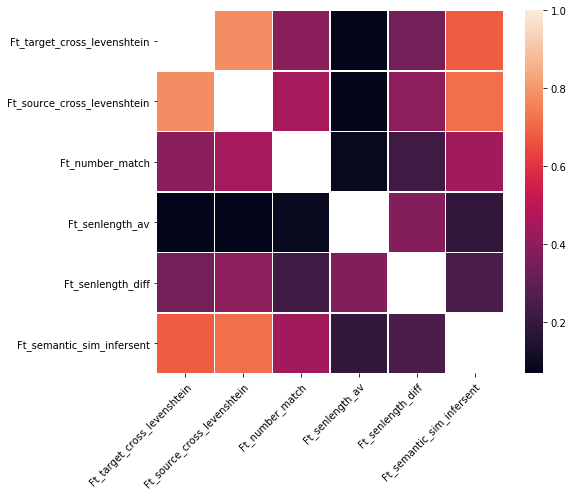

In [21]:
figsz=7
corr_matrix=np.abs( pd.DataFrame(  X_b_train, columns=feature_names ).corr())
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.diag_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(figsz*1.2,figsz))
sns.heatmap(corr_matrix, mask=mask,  linewidths=.3, )

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fig.tight_layout()


#### Regression utility function

In [22]:
def loss_r2(gold_lbls, pred_lbls): return (r2_score(gold_lbls,pred_lbls)) 
scorer = make_scorer(loss_r2, greater_is_better=True)

#### Supervised regression

In [24]:
feature_names

Index(['Ft_target_cross_levenshtein', 'Ft_source_cross_levenshtein',
       'Ft_number_match', 'Ft_senlength_av', 'Ft_senlength_diff',
       'Ft_semantic_sim_infersent'],
      dtype='object')

In [25]:
chosen_features=[ 'Ft_source_cross_levenshtein'  , 'Ft_number_match' , 'Ft_senlength_av',  'Ft_senlength_diff' , 'Ft_semantic_sim_infersent' ]

chosen_features_indices = []
for i in range( len( feature_names ) ):
    if feature_names[i] in chosen_features:
        chosen_features_indices.append( i )
        
chosen_features_indices

[1, 2, 3, 4, 5]

#### Check feature importance. 

In [26]:
from sklearn.model_selection import ShuffleSplit

splits=10
feature_importances=[]

rs = ShuffleSplit(n_splits=splits, test_size=0.25, random_state=0)

for train_index, test_index in rs.split( np.arange(len( X_b_train )) ):
    estimator = RandomForestRegressor(  n_estimators=500, max_depth=10, max_features='sqrt', min_samples_leaf=2, min_samples_split=2, random_state=1  )
    
    estimator.fit(X_b_train[ train_index ][:,chosen_features_indices], Y_b_train[ train_index][: ,0])
    feature_importances.append(     estimator.feature_importances_ )
    
feature_importances_all=np.array(feature_importances).reshape(splits,-1)
    
feature_importance_mean=np.mean(feature_importances_all , axis=0 )
feature_importance_std =np.std(feature_importances_all , axis=0 )
for feature, feature_importance_mean_, feature_importance_std_ in zip(  chosen_features , feature_importance_mean,   feature_importance_std  ):
    print(  feature, feature_importance_mean_, '+/-', feature_importance_std_  , '\n'  )

Ft_source_cross_levenshtein 0.5096346663252926 +/- 0.00854102099786912 

Ft_number_match 0.1193575366099745 +/- 0.011340709991795725 

Ft_senlength_av 0.05686683427156007 +/- 0.004079834746598657 

Ft_senlength_diff 0.082536174909884 +/- 0.011816283815402952 

Ft_semantic_sim_infersent 0.23160478788328848 +/- 0.006905311851532519 



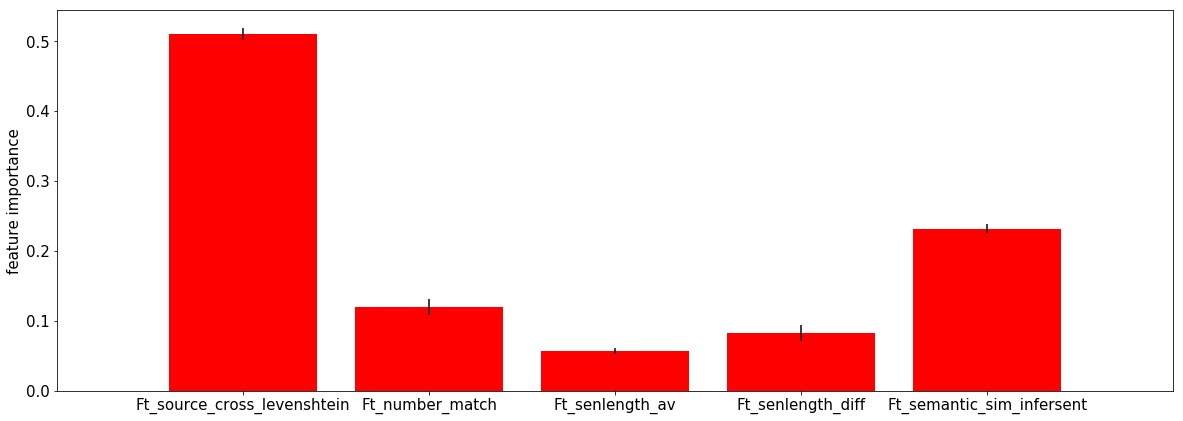

In [28]:
plt.figure()

plt.rcParams['figure.figsize'] = 20, 7
plt.rcParams.update({'font.size': 15})

plt.bar(range( len(chosen_features)  ), feature_importance_mean,
       color="r", yerr=feature_importance_std, align="center")
plt.xticks(range(  len(chosen_features)  ), chosen_features)
plt.xlim([-1, X.shape[1] -1 ]  )
plt.ylabel("feature importance")
plt.show()

##### Support vector machines

In [29]:
import time
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', SVR(kernel = 'rbf'))])

param_grid = dict(clf__C=np.logspace( -3,3,5 ),
                  clf__gamma=np.logspace(-3, 1, 8),
                  clf__epsilon=np.logspace(-6,-1,8)
                 )

estimator = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=20, verbose=1, scoring= scorer, return_train_score=True ) 

start=time.time()
estimator.fit(X_b_train[:, chosen_features_indices], Y_b_train[:,0])
end=time.time()

print( 'fitting done, took %.2f s' %(end-start) )

print(  'best params', estimator.cv_results_['params'][estimator.best_index_]  )

print( 'score:',  estimator.cv_results_['mean_train_score'][estimator.best_index_], '+/-', estimator.cv_results_['std_train_score'][estimator.best_index_] )

print( 'score:',  estimator.cv_results_['mean_test_score'][estimator.best_index_], '+/-', estimator.cv_results_['std_test_score'][estimator.best_index_] )

estimator_SVC=estimator

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    3.8s
[Parallel(n_jobs=20)]: Done 1506 tasks      | elapsed:  2.2min
[Parallel(n_jobs=20)]: Done 1561 out of 1600 | elapsed:  2.4min remaining:    3.6s
[Parallel(n_jobs=20)]: Done 1600 out of 1600 | elapsed:  2.6min finished


fitting done, took 155.07 s
best params {'clf__C': 1.0, 'clf__epsilon': 0.1, 'clf__gamma': 0.19306977288832497}
score: 0.8520280706604335 +/- 0.004374616518240196
score: 0.8284993005217522 +/- 0.019085354561178283


#### Random Forest regression

In [30]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', RandomForestRegressor( n_estimators= 500  ))])

param_grid = dict(clf__max_depth=[2,5,10,20,50 ],
                  clf__min_samples_split=[2,5,10 ],
                  clf__min_samples_leaf=[1, 2, 5,10      ],
                  clf__max_features=[ 'auto'  , 'sqrt' ,  'log2']
                 )

estimator = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=20, verbose=1, scoring= scorer, return_train_score=True )  #This is for GridSearchCV
#estimator = RandomizedSearchCV(pipe, param_distributions=param_grid, cv=2, n_jobs=20, verbose=2, scoring= scorer )

#estimator.fit(X_b_train[:,:-1], Y_b_train[:,0])
estimator.fit(X_b_train[:, chosen_features_indices ], Y_b_train[:,0])

print(  'best params', estimator.cv_results_['params'][estimator.best_index_]  )

print( 'score:',  estimator.cv_results_['mean_train_score'][estimator.best_index_], '+/-', estimator.cv_results_['std_train_score'][estimator.best_index_] )

print( 'score:',  estimator.cv_results_['mean_test_score'][estimator.best_index_], '+/-', estimator.cv_results_['std_test_score'][estimator.best_index_] )

estimator_RF=estimator

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   11.8s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   32.5s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  1.0min
[Parallel(n_jobs=20)]: Done 900 out of 900 | elapsed:  1.2min finished


best params {'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5}
score: 0.9471464092606846 +/- 0.003473900943332551
score: 0.8250859830062323 +/- 0.0345001062948991


#### Gradient boosted regressor

In [31]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', GradientBoostingRegressor( loss='ls',
                                             learning_rate=0.012, 
                                             max_depth=2,
                                             min_samples_leaf=2,
                                             min_samples_split=2,
                                             n_estimators=570
                                            )   )])

param_grid = dict(clf__learning_rate=[  0.001  , 0.012, 0.1 ,1],
                  clf__max_depth=[ 2,5,10,20,50  ],
                  clf__min_samples_leaf=[  2, 5, 10  ],
                  clf__min_samples_split=[ 2,5,10   ]
                 )

estimator = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=20, verbose=1, scoring= scorer, return_train_score=True )  #This is for GridSearchCV

estimator.fit(X_b_train[:, chosen_features_indices ], Y_b_train[:,0])


print(  'best params', estimator.cv_results_['params'][estimator.best_index_]  )

print( 'score:',  estimator.cv_results_['mean_train_score'][estimator.best_index_], '+/-', estimator.cv_results_['std_train_score'][estimator.best_index_] )

print( 'score:',  estimator.cv_results_['mean_test_score'][estimator.best_index_], '+/-', estimator.cv_results_['std_test_score'][estimator.best_index_] )

estimator_GB=estimator


Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    7.2s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   20.4s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   34.1s
[Parallel(n_jobs=20)]: Done 900 out of 900 | elapsed:   36.0s finished


best params {'clf__learning_rate': 0.012, 'clf__max_depth': 2, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 2}
score: 0.8672268598940255 +/- 0.0065212239488491855
score: 0.8101774014439624 +/- 0.039000265036704514


#### Elastic Net

In [32]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', ElasticNet( alpha=0.01, 
                            l1_ratio=0.5, max_iter=1000
                                            )   )])

param_grid = dict(clf__alpha=[ 0, 0.001 , 0.01 , 0.1 , 1 , 10 , 100 ],
                  clf__l1_ratio=[ 0, 0.25, 0.5, 0.75, 1  ],
                  clf__tol=[  0.00001 ,0.0001, 0.001, 0.01   ],
                  
                 )

estimator = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=20, verbose=1, scoring= scorer, return_train_score=True )  #This is for GridSearchCV

estimator.fit(X_b_train[:, chosen_features_indices ], Y_b_train[:,0])


print(  'best params', estimator.cv_results_['params'][estimator.best_index_]  )

print( 'score:',  estimator.cv_results_['mean_train_score'][estimator.best_index_], '+/-', estimator.cv_results_['std_train_score'][estimator.best_index_] )

print( 'score:',  estimator.cv_results_['mean_test_score'][estimator.best_index_], '+/-', estimator.cv_results_['std_test_score'][estimator.best_index_] )

estimator_EN=estimator

Fitting 5 folds for each of 140 candidates, totalling 700 fits


/miniconda/lib/python3.6/site-packages/sklearn/pipeline.py:259: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/miniconda/lib/python3.6/site-packages/sklearn/pipeline.py:259: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/miniconda/lib/python3.6/site-packages/sklearn/pipeline.py:259: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarni

/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/lib/python3.6/site-packages/sklearn/pipeline.py:259: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/miniconda/l

/miniconda/lib/python3.6/site-packages/sklearn/pipeline.py:259: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/lib/python3.6/site-packages/sklearn/pipeline.py:259: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/miniconda/lib/python3.6/site-packages/sklearn/pipeline.py:259: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/miniconda/lib/python3.6/s

/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/lib/python3.6/site-packages/sklearn/pipeline.py:259: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/l

/miniconda/lib/python3.6/site-packages/sklearn/pipeline.py:259: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/lib/python3.6/site-packages/sklearn/pipeline.py:259: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y

/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/lib/python3.6/site-packages/sklearn/pipeline.py:259: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/miniconda/lib/python3.6/site-packages/sklearn/pipeline.py:259: UserWarning: With 

/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/lib/python3.6/site-packages/sklearn/pipeline.py:259: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small 

/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/lib/python3.6/site-packages/sklearn/pipeline.py:259: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small 

/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/lib/python3.6/site-packages/sklearn/pipeline.py:259: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/lib/python3.6/site-packages/sklearn/pipeline.py:259: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y

/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/lib/python3.6/site-packages/sklearn/pipeline.py:259: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression e

/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


best params {'clf__alpha': 0.01, 'clf__l1_ratio': 0, 'clf__tol': 1e-05}
score: 0.7226320948311141 +/- 0.00786717013877319
score: 0.7148818137006631 +/- 0.032824525674024836


[Parallel(n_jobs=20)]: Done 700 out of 700 | elapsed:    0.9s finished
/miniconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


#### determine threshold for classification (on the held out test set)

In [34]:
#some helper functions:
def utility(gold_cls, pred_cls, p=0.33): return ( true_negative_rate(gold_cls, pred_cls)**(1-p)*recall_score(gold_cls, pred_cls)**p )  #AD: Calculate mean biased towards recall score.
def true_negative_rate(gold_cls, pred_cls): return confusion_matrix(gold_cls, pred_cls)[0,0]/(confusion_matrix(gold_cls, pred_cls)[0,0]+confusion_matrix(gold_cls, pred_cls)[0,1])
def root_relative_square_error(gold, pred): 
    from sklearn.metrics import mean_squared_error
    return (    mean_squared_error( gold  , pred  ) / mean_squared_error( gold  , np.repeat(np.mean(gold), len(gold)  )  )    )**0.5

In [35]:
estimator = estimator_SVC

predicted_labels=estimator.predict(X_test[:, chosen_features_indices ]  )
gold_labels=Y_test[:,0]
gold_classification=Y_test[:,1]

thresholds = np.linspace(0,4,num=30)
utility_of_threshold=[]

for t in thresholds:
    predicted_classification=(predicted_labels>t).astype(int)  #so if predicted label is larger than t==>than classified as misaligned. 
    utility_of_threshold.append(  utility(  gold_classification , predicted_classification   ))
    
optimal_threshold= thresholds[ np.argmax(utility_of_threshold) ]  #use utility score as a measure to determine optimal threshold.  
print( 'optimal threshold is: %.2f \n' % optimal_threshold )

predicted_classification=(predicted_labels > optimal_threshold ).astype(int)

#Classification metrics:
true_pos= recall_score( gold_classification, predicted_classification  )
true_neg=true_negative_rate(  gold_classification, predicted_classification )
utility_score=utility( gold_classification, predicted_classification )
AUC=roc_auc_score( gold_classification , predicted_labels )

#Regression metrics:
pearsonR=pearsonr( gold_labels, predicted_labels )[0]
Rsquare=r2_score(  gold_labels, predicted_labels )
rrR=root_relative_square_error( gold_labels, predicted_labels )

print( "When using optimal threshold, we get following scores:\n" )

print( "Classification metrics:" )
print( "true pos: %.2f|" % true_pos ,  "true neg: %.2f|" % true_neg , "area under the curve: %.2f|" % AUC , "utility: %.2f|" % utility_score)
      
print( "Regression metrics:" )
print( "R-pearson: %.2f|" %pearsonR, "R2: %.2f|" %Rsquare, "root relative square: %.2f" %rrR )


optimal threshold is: 2.21 

When using optimal threshold, we get following scores:

Classification metrics:
true pos: 0.90| true neg: 0.98| area under the curve: 0.97| utility: 0.95|
Regression metrics:
R-pearson: 0.86| R2: 0.73| root relative square: 0.52


Text(2.15, 2.0485632183908047, 'classification threshold = 2.21')

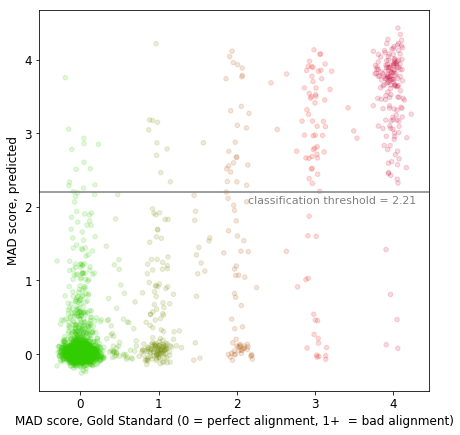

In [37]:
#plot the predicted versus the real labels:

jw=0.10
size=7

x=gold_labels
y=predicted_labels

x_jitter = np.minimum(3*jw, np.maximum(-3*jw,   np.random.normal(0.0, jw, X_test.shape[0] )     ))
y_jitter = 0

plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(size,size))
red_green_cm = plt.get_cmap('brg_r') 

ax.scatter(x+x_jitter, y +y_jitter, s=size*3, c = red_green_cm(0.1 + x*(1/8  ) ), alpha = 0.15)
ax.set_xlabel("MAD score, Gold Standard (0 = perfect alignment, 1+  = bad alignment)")
ax.set_ylabel("MAD score, predicted")

plt.axhline(y= optimal_threshold , color='grey' )


plt.text(x = 1.8 + size/20 , y = optimal_threshold - 0.1 - 0.2*size/24 , s='classification threshold = %.2f' %optimal_threshold , fontsize=size+4, color='grey')



#### Draw the learning curve

In [38]:
import time
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', SVR(kernel = 'rbf'))])

param_grid = dict(clf__C=np.logspace( -3,3,5 ),
                  clf__gamma=np.logspace(-3, 1, 8),
                  clf__epsilon=np.logspace(-6,-1,8)
                 )

train_mean=[]
train_std=[]
test_mean=[]
test_std=[]

train_sizes= np.linspace( 100, X_b_train.shape[0], 10 ).astype(int)

for number_of_samples in train_sizes:

    estimator = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=20, verbose=1, scoring= scorer, return_train_score=True )  #This is for GridSearchCV
    
    print( 'results with %.2f number of samples:' % number_of_samples )
    
    start=time.time()
    estimator.fit(X_b_train[:number_of_samples, chosen_features_indices], Y_b_train[:number_of_samples,0])
    end=time.time()
    
    print( 'fitting done, took %.2f s' %(end-start) )

    print(  'best params', estimator.cv_results_['params'][estimator.best_index_]  )

    print( 'score:',  estimator.cv_results_['mean_train_score'][estimator.best_index_], '+/-', estimator.cv_results_['std_train_score'][estimator.best_index_] )

    print( 'score:',  estimator.cv_results_['mean_test_score'][estimator.best_index_], '+/-', estimator.cv_results_['std_test_score'][estimator.best_index_] )

    train_mean.append( estimator.cv_results_['mean_train_score'][estimator.best_index_] )
    train_std.append(  estimator.cv_results_['std_train_score'][estimator.best_index_] )
    test_mean.append( estimator.cv_results_['mean_test_score'][estimator.best_index_] )
    test_std.append(  estimator.cv_results_['std_test_score'][estimator.best_index_] )

results with 100.00 number of samples:
Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=20)]: Done  76 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 1600 out of 1600 | elapsed:    2.7s finished


fitting done, took 3.76 s
best params {'clf__C': 31.622776601683793, 'clf__epsilon': 0.1, 'clf__gamma': 0.013894954943731374}
score: 0.7954392695234489 +/- 0.0502222494475409
score: 0.6643630048526762 +/- 0.15563976711462724
results with 185.00 number of samples:
Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=20)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done 1600 out of 1600 | elapsed:    6.2s finished


fitting done, took 7.33 s
best params {'clf__C': 1.0, 'clf__epsilon': 0.1, 'clf__gamma': 0.19306977288832497}
score: 0.8484239364962092 +/- 0.015302194909971752
score: 0.7625554724420746 +/- 0.08886943470125373
results with 270.00 number of samples:
Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=20)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 1600 out of 1600 | elapsed:   14.8s finished


fitting done, took 15.88 s
best params {'clf__C': 1.0, 'clf__epsilon': 0.1, 'clf__gamma': 0.19306977288832497}
score: 0.8572508874542987 +/- 0.013531893740110096
score: 0.7951989731443221 +/- 0.04549341621865567
results with 355.00 number of samples:
Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1600 out of 1600 | elapsed:   27.3s finished


fitting done, took 28.41 s
best params {'clf__C': 1.0, 'clf__epsilon': 0.1, 'clf__gamma': 0.19306977288832497}
score: 0.849219976907332 +/- 0.0033812723368560537
score: 0.798383028087111 +/- 0.03775806334784761
results with 440.00 number of samples:
Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1600 out of 1600 | elapsed:   42.8s finished


fitting done, took 43.96 s
best params {'clf__C': 1.0, 'clf__epsilon': 0.1, 'clf__gamma': 0.19306977288832497}
score: 0.8564601208561579 +/- 0.006609790585768818
score: 0.8133557961833654 +/- 0.03923765611118313
results with 525.00 number of samples:
Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1600 out of 1600 | elapsed:  1.1min finished


fitting done, took 69.97 s
best params {'clf__C': 1.0, 'clf__epsilon': 0.1, 'clf__gamma': 0.19306977288832497}
score: 0.8506954753948979 +/- 0.00920378084554979
score: 0.8196013949991998 +/- 0.04118191764344131
results with 610.00 number of samples:
Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1240 tasks      | elapsed:    6.6s
[Parallel(n_jobs=20)]: Done 1600 out of 1600 | elapsed:  1.7min finished


fitting done, took 102.59 s
best params {'clf__C': 1.0, 'clf__epsilon': 0.1, 'clf__gamma': 0.19306977288832497}
score: 0.8444855309864512 +/- 0.0049840541920961835
score: 0.8158022022290731 +/- 0.0229340536344158
results with 695.00 number of samples:
Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    2.5s
[Parallel(n_jobs=20)]: Done 1521 tasks      | elapsed:  1.2min
[Parallel(n_jobs=20)]: Done 1561 out of 1600 | elapsed:  1.3min remaining:    1.9s
[Parallel(n_jobs=20)]: Done 1600 out of 1600 | elapsed:  1.9min finished


fitting done, took 112.70 s
best params {'clf__C': 1.0, 'clf__epsilon': 0.1, 'clf__gamma': 0.19306977288832497}
score: 0.8549605317743605 +/- 0.005487448956044904
score: 0.8277447326783454 +/- 0.01873701518984402
results with 780.00 number of samples:
Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1000 tasks      | elapsed:    4.8s
[Parallel(n_jobs=20)]: Done 1600 out of 1600 | elapsed:  2.5min finished


fitting done, took 153.79 s
best params {'clf__C': 1.0, 'clf__epsilon': 0.1, 'clf__gamma': 0.19306977288832497}
score: 0.8581080703836633 +/- 0.008177279417953131
score: 0.8361083502835 +/- 0.040555684445402355
results with 866.00 number of samples:
Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 1000 tasks      | elapsed:    5.6s
[Parallel(n_jobs=20)]: Done 1561 out of 1600 | elapsed:  2.4min remaining:    3.6s
[Parallel(n_jobs=20)]: Done 1600 out of 1600 | elapsed:  2.9min finished


fitting done, took 176.54 s
best params {'clf__C': 1.0, 'clf__epsilon': 0.1, 'clf__gamma': 0.19306977288832497}
score: 0.8520280706604335 +/- 0.004374616518240196
score: 0.8284993005217522 +/- 0.019085354561178283


(0.53, 1.0)

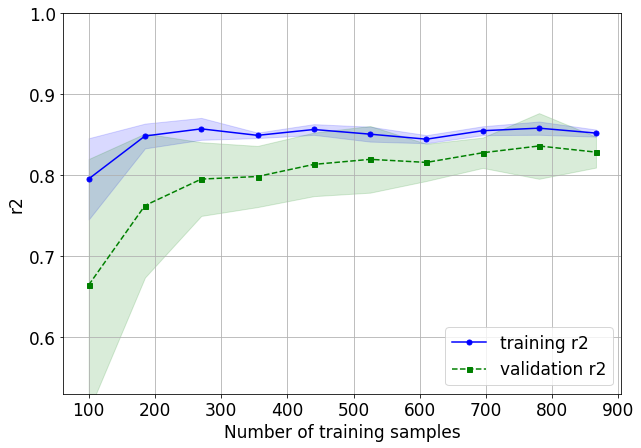

In [39]:
plt.rcParams['figure.figsize'] = 10, 7
plt.rcParams.update({'font.size': 17})
plt.plot( train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training r2')
plt.fill_between(train_sizes, np.array(train_mean) + np.array(train_std), np.array(train_mean) - np.array(train_std), alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation r2')
plt.fill_between(train_sizes, np.array(test_mean) + np.array(test_std), np.array(test_mean) - np.array(test_std), alpha=0.15, color='green')
plt.grid()
plt.xlabel( 'Number of training samples' )
plt.ylabel( 'r2' )
plt.legend( loc='lower right' )
plt.ylim([0.53, 1.0])

# END